 # ADDA for ST

 Creating something like CellDART but it actually follows Adda in PyTorch as a first step

In [1]:
import math
from math import ceil
import glob
import os
import datetime

from tqdm.autonotebook import tqdm

import h5py
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ad

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import mean_squared_error

import torch
from torch.nn import functional as F
from torch import nn

from src.model.adda import ADDAST
from src.model.datasets import SpotDataset
from src.utils.data_processing import random_mix

# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")


/tmp/ipykernel_53662/2201409796.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# NUM_MARKERS = 20
# N_MIX = 8
# N_SPOTS = 20000
TRAIN_USING_ALL_ST_SAMPLES = False

SAMPLE_ID_N = "151673"

BATCH_SIZE = 1024
NUM_WORKERS = 8
INITIAL_TRAIN_EPOCHS = 100


MIN_EPOCHS = 0.4 * INITIAL_TRAIN_EPOCHS
EARLY_STOP_CRIT = INITIAL_TRAIN_EPOCHS

PROCESSED_DATA_DIR = "data/preprocessed"


In [3]:
results_folder = os.path.join("results", script_start_time)
model_folder = os.path.join("model", script_start_time)

model_folder = os.path.join("model", "TESTING")

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)

if not os.path.isdir(results_folder):
    os.makedirs(results_folder)


In [4]:
# sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3


 # Data load

In [5]:
# Load spatial data
mat_sp_test_s_d = {}
with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_test_s_d.hdf5"), "r") as f:
    for sample_id in f:
        mat_sp_test_s_d[sample_id] = f[sample_id][()]

if TRAIN_USING_ALL_ST_SAMPLES:
    with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_train_s.hdf5"), "r") as f:
        mat_sp_train_s = f["all"][()]
else:
    mat_sp_train_s_d = mat_sp_test_s_d

# Load sc data
with h5py.File(os.path.join(PROCESSED_DATA_DIR, "sc.hdf5"), "r") as f:
    sc_mix_train_s = f["X/train"][()]
    sc_mix_val_s = f["X/val"][()]
    sc_mix_test_s = f["X/test"][()]

    lab_mix_train = f["y/train"][()]
    lab_mix_val = f["y/val"][()]
    lab_mix_test = f["y/test"][()]

# Load helper dicts / lists
with open(os.path.join(PROCESSED_DATA_DIR, "sc_sub_dict.pkl"), "rb") as f:
    sc_sub_dict = pickle.load(f)

with open(os.path.join(PROCESSED_DATA_DIR, "sc_sub_dict2.pkl"), "rb") as f:
    sc_sub_dict2 = pickle.load(f)

with open(os.path.join(PROCESSED_DATA_DIR, "st_sample_id_l.pkl"), "rb") as f:
    st_sample_id_l = pickle.load(f)


 # Training: Adversarial domain adaptation for cell fraction estimation

 ## Prepare dataloaders

In [6]:
### source dataloaders
source_train_set = SpotDataset(sc_mix_train_s, lab_mix_train)
source_val_set = SpotDataset(sc_mix_val_s, lab_mix_val)
source_test_set = SpotDataset(sc_mix_test_s, lab_mix_test)

dataloader_source_train = torch.utils.data.DataLoader(
    source_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
dataloader_source_val = torch.utils.data.DataLoader(
    source_val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
dataloader_source_test = torch.utils.data.DataLoader(
    source_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

### target dataloaders
target_test_set_d = {}
for sample_id in st_sample_id_l:
    target_test_set_d[sample_id] = SpotDataset(mat_sp_test_s_d[sample_id])

dataloader_target_test_d = {}
for sample_id in st_sample_id_l:
    dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
        target_test_set_d[sample_id],
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

if TRAIN_USING_ALL_ST_SAMPLES:
    target_train_set = SpotDataset(mat_sp_train_s)
    dataloader_target_train = torch.utils.data.DataLoader(
        target_train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
else:
    target_train_set_d = {}
    dataloader_target_train_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(mat_sp_test_s_d[sample_id])
        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=True,
        )


 ## Define Model

In [7]:
model = ADDAST(sc_mix_train_s.shape[1], emb_dim=64, ncls_source=lab_mix_train.shape[1])
model.to(device)


ADDAST(
  (source_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=367, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (target_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=367, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (clf): Predictor(
    (head): Sequential(
      (0): Linear(in_features=64, out_features=33, bias=True)
      (1): Log

 ## Pretrain

In [8]:
pretrain_folder = os.path.join(model_folder, "pretrain")

if not os.path.isdir(pretrain_folder):
    os.makedirs(pretrain_folder)


In [9]:
pre_optimizer = torch.optim.Adam(
    model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-07
)

pre_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    pre_optimizer,
    max_lr=0.002,
    steps_per_epoch=len(dataloader_source_train),
    epochs=INITIAL_TRAIN_EPOCHS,
)

criterion_clf = nn.KLDivLoss(reduction="batchmean")


In [10]:
def model_loss(x, y_true, model):
    x = x.to(torch.float32).to(device)
    y_true = y_true.to(torch.float32).to(device)

    y_pred = model(x)

    loss = criterion_clf(y_pred, y_true)

    return loss


def compute_acc(dataloader, model):
    loss_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(dataloader):

            loss = model_loss(*batch, model)

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(batch))

    return np.average(loss_running, weights=mean_weights)


In [11]:
model.pretraining()


In [12]:
# Initialize lists to store loss and accuracy values
loss_history = []
loss_history_val = []

loss_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0


# Train
print("Start pretrain...")
outer = tqdm(total=INITIAL_TRAIN_EPOCHS, desc="Epochs", position=0)
inner = tqdm(total=len(dataloader_source_train), desc=f"Batch", position=1)

checkpoint = {
    "epoch": -1,
    "model": model,
    "optimizer": pre_optimizer,
    "scheduler": pre_scheduler,
    # 'scaler': scaler
}
for epoch in range(INITIAL_TRAIN_EPOCHS):

    # check to see if validation loss has plateau'd
    if early_stop_count >= EARLY_STOP_CRIT and epoch > MIN_EPOCHS:
        print(
            f"Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch"
        )
        checkpoint["epoch"] = epoch
        torch.save(checkpoint, os.path.join(pretrain_folder, f"earlystop_{epoch}.pth"))
        break

    early_stop_count += 1

    # Train mode
    model.train()
    loss_running = []
    mean_weights = []

    inner.refresh()  # force print final state
    inner.reset()  # reuse bar
    for _, batch in enumerate(dataloader_source_train):
        # lr_history_running.append(scheduler.get_last_lr())

        pre_optimizer.zero_grad()
        loss = model_loss(*batch, model)
        loss_running.append(loss.item())
        mean_weights.append(len(batch))  # we will weight average by batch size later

        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        loss.backward()
        pre_optimizer.step()
        pre_scheduler.step()

        inner.update(1)

    loss_history.append(np.average(loss_running, weights=mean_weights))
    loss_history_running.append(loss_running)

    # Evaluate mode
    model.eval()
    with torch.no_grad():
        curr_loss_val = compute_acc(dataloader_source_val, model)
        loss_history_val.append(curr_loss_val)

    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint["epoch"] = epoch
        torch.save(checkpoint, os.path.join(pretrain_folder, f"best_model.pth"))
        early_stop_count = 0

    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= INITIAL_TRAIN_EPOCHS - 1:
        checkpoint["epoch"] = epoch
        torch.save(checkpoint, os.path.join(pretrain_folder, f"checkpt{epoch}.pth"))

    # Print the results
    outer.update(1)
    print(
        "epoch:",
        epoch,
        "train loss:",
        round(loss_history[-1], 6),
        "validation loss:",
        round(loss_history_val[-1], 6),
        # "next_lr:", scheduler.get_last_lr(),
    )

# Save final model
checkpoint["epoch"] = epoch
torch.save(checkpoint, os.path.join(pretrain_folder, f"final_model.pth"))


Start pretrain...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 train loss: 1.751116 validation loss: 1.575489
epoch: 1 train loss: 1.480168 validation loss: 1.413222
epoch: 2 train loss: 1.373513 validation loss: 1.316302
epoch: 3 train loss: 1.301459 validation loss: 1.259338
epoch: 4 train loss: 1.239514 validation loss: 1.206363
epoch: 5 train loss: 1.179124 validation loss: 1.151294
epoch: 6 train loss: 1.116222 validation loss: 1.086433
epoch: 7 train loss: 1.050312 validation loss: 1.016365
epoch: 8 train loss: 0.980731 validation loss: 0.979047
epoch: 9 train loss: 0.906866 validation loss: 0.881969
epoch: 10 train loss: 0.831896 validation loss: 0.860009
epoch: 11 train loss: 0.758583 validation loss: 0.780945
epoch: 12 train loss: 0.690317 validation loss: 0.714417
epoch: 13 train loss: 0.634064 validation loss: 0.680079
epoch: 14 train loss: 0.591471 validation loss: 0.661462
epoch: 15 train loss: 0.561814 validation loss: 0.669135
epoch: 16 train loss: 0.541665 validation loss: 0.670047
epoch: 17 train loss: 0.523074 validation

 ## Adversarial Adaptation

In [13]:
EPOCHS = 50
MIN_EPOCHS_ADV = 0.4 * EPOCHS
EARLY_STOP_CRIT_ADV = EPOCHS


In [14]:
advtrain_folder = os.path.join(model_folder, "advtrain")

if not os.path.isdir(advtrain_folder):
    os.makedirs(advtrain_folder)


In [15]:
def cycle_iter(iter):
    while True:
        yield from iter


In [16]:
criterion_dis = nn.CrossEntropyLoss()


In [17]:
def discrim_loss_accu(x_source, x_target, model):
    x_source, x_target = x_source.to(device), x_target.to(device)
    y_dis = torch.cat(
        [
            torch.zeros(x_source.shape[0], device=device, dtype=torch.long),
            torch.ones(x_target.shape[0], device=device, dtype=torch.long),
        ]
    )

    emb_source = model.source_encoder(x_source).view(x_source.shape[0], -1)
    emb_target = model.target_encoder(x_target).view(x_target.shape[0], -1)

    emb_all = torch.cat((emb_source, emb_target))

    y_pred = model.dis(emb_all)

    loss = criterion_dis(y_pred, y_dis)
    accu = torch.mean(
        (torch.flatten(torch.argmax(y_pred, dim=1)) == y_dis).to(torch.float32)
    ).cpu()

    return loss, accu


def encoder_loss(x_target, model):
    x_target = x_target.to(device)

    # flip label
    y_dis = torch.zeros(x_target.shape[0], device=device, dtype=torch.long)

    emb_target = model.target_encoder(x_target).view(x_target.shape[0], -1)
    y_pred = model.dis(emb_target)
    loss = criterion_dis(y_pred, y_dis)

    return loss


In [18]:
from re import X


def train_adversarial(
    model,
    save_folder,
    dataloader_source_train,
    dataloader_source_val,
    dataloader_target_train,
):
    model.to(device)
    model.advtraining()

    target_optimizer = torch.optim.Adam(
        model.target_encoder.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-07
    )
    dis_optimizer = torch.optim.Adam(
        model.dis.parameters(), lr=0.00025, betas=(0.9, 0.999), eps=1e-07
    )

    iters = max(len(dataloader_source_train), len(dataloader_target_train))

    dis_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        dis_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
    )
    target_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        target_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
    )

    checkpoint = {
        "epoch": -1,
        "model": model,
        "dis_optimizer": dis_optimizer,
        "target_optimizer": target_optimizer,
        "dis_scheduler": dis_scheduler,
        "target_scheduler": target_scheduler,
    }
    n_samples_source = len(dataloader_source_train.dataset)
    n_samples_target = len(dataloader_target_train.dataset)
    p = n_samples_source / (n_samples_source + n_samples_target)
    rand_loss = -(p * np.log(0.5)) - (1 - p) * np.log(0.5)

    # Initialize lists to store loss and accuracy values
    loss_history = []
    accu_history = []
    loss_history_running = []

    # Early Stopping
    best_loss_val = np.inf
    early_stop_count = 0

    # Train
    print("Start adversarial training...")
    print("Discriminator target loss:", rand_loss)
    outer = tqdm(total=EPOCHS, desc="Epochs", position=0)
    inner1 = tqdm(total=iters, desc=f"Batch (Discriminator)", position=1)
    inner2 = tqdm(total=iters, desc=f"Batch (Encoder)", position=2)
    for epoch in range(EPOCHS):
        # check to see if validation loss has plateau'd
        if early_stop_count >= EARLY_STOP_CRIT_ADV and epoch > MIN_EPOCHS_ADV:
            print(
                f"Discriminator loss plateaud; failed to get worse after {early_stop_count} at {epoch}th epoch"
            )
            checkpoint["epoch"] = epoch
            torch.save(checkpoint, os.path.join(save_folder, f"earlystop_{epoch}.pth"))
            break

        early_stop_count += 1

        # Train mode
        model.train()

        loss_running = []
        accu_running = []
        mean_weights = []

        inner1.refresh()  # force print final state
        inner1.reset()  # reuse bar
        inner2.refresh()  # force print final state
        inner2.reset()  # reuse bar

        model.train_discriminator()
        model.target_encoder.eval()
        model.source_encoder.eval()
        model.dis.train()
        batch_cycler = zip(
            cycle_iter(dataloader_source_train), cycle_iter(dataloader_target_train)
        )
        for _ in range(iters):
            # lr_history_running.append(scheduler.get_last_lr())
            dis_optimizer.zero_grad()

            (x_source, _), (x_target, _) = next(batch_cycler)
            loss, accu = discrim_loss_accu(x_source, x_target, model)
            loss_running.append(loss.item())
            accu_running.append(accu)
            mean_weights.append(len(x_source) + len(x_target))

            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()

            loss.backward()
            dis_optimizer.step()
            dis_scheduler.step()

            inner1.update(1)

        loss_history.append(np.average(loss_running, weights=mean_weights))
        accu_history.append(np.average(accu_running, weights=mean_weights))
        loss_history_running.append(loss_running)

        model.train_target_encoder()
        model.target_encoder.train()
        model.source_encoder.eval()
        model.dis.eval()
        batch_cycler = zip(
            cycle_iter(dataloader_source_train), cycle_iter(dataloader_target_train)
        )
        for _ in range(iters):
            target_optimizer.zero_grad()

            _, (x_target, _) = next(batch_cycler)
            loss = encoder_loss(x_target, model)

            loss.backward()
            target_optimizer.step()
            target_scheduler.step()

            inner2.update(1)

        # Save the best weights
        if math.fabs(loss_history[-1] - rand_loss) < best_loss_val:
            best_loss_val = math.fabs(loss_history[-1] - rand_loss)
            checkpoint["epoch"] = epoch
            torch.save(checkpoint, os.path.join(save_folder, f"best_model.pth"))
            early_stop_count = 0

        # Save checkpoint every 10
        if epoch % 10 == 0 or epoch >= EPOCHS - 1:
            checkpoint["epoch"] = epoch
            torch.save(checkpoint, os.path.join(save_folder, f"checkpt{epoch}.pth"))

        # Print the results
        outer.update(1)
        print(
            "epoch:",
            epoch,
            "dis loss:",
            round(loss_history[-1], 6),
            "dis accu:",
            round(accu_history[-1], 6),
            "difference from random loss:",
            round(math.fabs(loss_history[-1] - rand_loss), 6)
            # "next_lr:", scheduler.get_last_lr(),
        )

    # Save final model
    checkpoint["epoch"] = epoch
    torch.save(checkpoint, os.path.join(save_folder, f"final_model.pth"))


In [19]:
st_sample_id_l = [SAMPLE_ID_N]


In [20]:
if TRAIN_USING_ALL_ST_SAMPLES:
    print(f"Adversarial training for all ST slides")
    save_folder = advtrain_folder

    best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
    model = best_checkpoint["model"]
    model.to(device)
    model.advtraining()

    train_adversarial(
        model,
        save_folder,
        dataloader_source_train,
        dataloader_source_val,
        dataloader_target_train,
    )

else:
    for sample_id in st_sample_id_l:
        print(f"Adversarial training for ST slide {sample_id}: ")

        save_folder = os.path.join(advtrain_folder, sample_id)
        if not os.path.isdir(save_folder):
            os.makedirs(save_folder)

        best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
        model = best_checkpoint["model"]
        model.to(device)
        model.advtraining()

        train_adversarial(
            model,
            save_folder,
            dataloader_source_train,
            dataloader_source_val,
            dataloader_target_train_d[sample_id],
        )


Adversarial training for ST slide 151673: 
Start adversarial training...
Discriminator target loss: 0.6931471805599453


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batch (Discriminator):   0%|          | 0/20 [00:00<?, ?it/s]

Batch (Encoder):   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 dis loss: 0.849375 dis accu: 0.290562 difference from random loss: 0.156228
epoch: 1 dis loss: 0.830054 dis accu: 0.443016 difference from random loss: 0.136907
epoch: 2 dis loss: 0.844838 dis accu: 0.418746 difference from random loss: 0.151691
epoch: 3 dis loss: 0.860821 dis accu: 0.401361 difference from random loss: 0.167673
epoch: 4 dis loss: 0.852996 dis accu: 0.401937 difference from random loss: 0.159849
epoch: 5 dis loss: 0.826189 dis accu: 0.422228 difference from random loss: 0.133041
epoch: 6 dis loss: 0.768581 dis accu: 0.486503 difference from random loss: 0.075434
epoch: 7 dis loss: 0.721051 dis accu: 0.541249 difference from random loss: 0.027903
epoch: 8 dis loss: 0.673689 dis accu: 0.598298 difference from random loss: 0.019458
epoch: 9 dis loss: 0.615044 dis accu: 0.676738 difference from random loss: 0.078103
epoch: 10 dis loss: 0.55763 dis accu: 0.741039 difference from random loss: 0.135517
epoch: 11 dis loss: 0.516925 dis accu: 0.779893 difference from r

## Evaluation of latent space

In [21]:
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier


for sample_id in st_sample_id_l:
    best_checkpoint = torch.load(
        os.path.join(advtrain_folder, sample_id, f"final_model.pth")
    )
    model = best_checkpoint["model"]
    model.to(device)

    model.eval()
    model.target_inference()

    with torch.no_grad():
        source_emb = model.source_encoder(torch.Tensor(sc_mix_train_s).to(device))
        target_emb = model.target_encoder(
            torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)
        )

        y_dis = torch.cat(
            [
                torch.zeros(source_emb.shape[0], device=device, dtype=torch.long),
                torch.ones(target_emb.shape[0], device=device, dtype=torch.long),
            ]
        )

        emb = torch.cat([source_emb, target_emb])

        emb = emb.detach().cpu().numpy()
        y_dis = y_dis.detach().cpu().numpy()

    (emb_train, emb_test, y_dis_train, y_dis_test,) = model_selection.train_test_split(
        emb,
        y_dis,
        test_size=0.2,
        random_state=225,
        stratify=y_dis,
    )

    pca = PCA(n_components=50)
    pca.fit(emb_train)

    emb_train_50 = pca.transform(emb_train)
    emb_test_50 = pca.transform(emb_test)

    clf = RandomForestClassifier(random_state=145, n_jobs=-1)
    clf.fit(emb_train_50, y_dis_train)
    accu_train = clf.score(emb_train_50, y_dis_train)
    accu_test = clf.score(emb_test_50, y_dis_test)
    class_proportions = np.mean(y_dis)

    print(
        "Training accuracy: {}, Test accuracy: {}, Class proportions: {}".format(
            accu_train, accu_test, class_proportions
        )
    )


Training accuracy: 1.0, Test accuracy: 0.9877326565143824, Class proportions: 0.1539405220186979


 # 4. Predict cell fraction of spots and visualization

In [22]:
pred_sp_d, pred_sp_noda_d = {}, {}
if TRAIN_USING_ALL_ST_SAMPLES:
    best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
    model = best_checkpoint["model"]
    model.to(device)

    model.eval()
    model.target_inference()
    with torch.no_grad():
        for sample_id in st_sample_id_l:
            pred_sp_d[sample_id] = (
                torch.exp(
                    model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device))
                )
                .detach()
                .cpu()
                .numpy()
            )

else:
    for sample_id in st_sample_id_l:
        best_checkpoint = torch.load(
            os.path.join(advtrain_folder, sample_id, f"final_model.pth")
        )
        model = best_checkpoint["model"]
        model.to(device)

        model.eval()
        model.target_inference()

        with torch.no_grad():
            pred_sp_d[sample_id] = (
                torch.exp(
                    model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device))
                )
                .detach()
                .cpu()
                .numpy()
            )


best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
model = best_checkpoint["model"]
model.to(device)

model.eval()
model.set_encoder("source")

with torch.no_grad():
    for sample_id in st_sample_id_l:
        pred_sp_noda_d[sample_id] = (
            torch.exp(model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)))
            .detach()
            .cpu()
            .numpy()
        )


In [23]:
adata_spatialLIBD = sc.read_h5ad(
    os.path.join(PROCESSED_DATA_DIR, "adata_spatialLIBD.h5ad")
)

adata_spatialLIBD_d = {}
for sample_id in st_sample_id_l:
    adata_spatialLIBD_d[sample_id] = adata_spatialLIBD[
        adata_spatialLIBD.obs.sample_id == sample_id
    ]
    adata_spatialLIBD_d[sample_id].obsm["spatial"] = (
        adata_spatialLIBD_d[sample_id].obs[["X", "Y"]].values
    )


In [24]:
num_name_exN_l = []
for k, v in sc_sub_dict.items():
    if "Ex" in v:
        num_name_exN_l.append((k, v, int(v.split("_")[1])))
num_name_exN_l.sort(key=lambda a: a[2])
num_name_exN_l


[(4, 'Ex_1_L5_6', 1),
 (5, 'Ex_2_L5', 2),
 (6, 'Ex_3_L4_5', 3),
 (7, 'Ex_4_L_6', 4),
 (8, 'Ex_5_L5', 5),
 (9, 'Ex_6_L4_6', 6),
 (10, 'Ex_7_L4_6', 7),
 (11, 'Ex_8_L5_6', 8),
 (12, 'Ex_9_L5_6', 9),
 (13, 'Ex_10_L2_4', 10)]

In [25]:
Ex_to_L_d = {
    1: {5, 6},
    2: {5},
    3: {4, 5},
    4: {6},
    5: {5},
    6: {4, 5, 6},
    7: {4, 5, 6},
    8: {5, 6},
    9: {5, 6},
    10: {2, 3, 4},
}


In [26]:
numlist = [t[0] for t in num_name_exN_l]
Ex_l = [t[2] for t in num_name_exN_l]
num_to_ex_d = dict(zip(numlist, Ex_l))


In [27]:
def plot_cellfraction(visnum, adata, pred_sp, ax=None):
    """Plot predicted cell fraction for a given visnum"""
    adata.obs["Pred_label"] = pred_sp[:, visnum]
    # vmin = 0
    # vmax = np.amax(pred_sp)

    sc.pl.spatial(
        adata,
        img_key="hires",
        color="Pred_label",
        palette="Set1",
        size=1.5,
        legend_loc=None,
        title=f"{sc_sub_dict[visnum]}",
        spot_size=100,
        show=False,
        # vmin=vmin,
        # vmax=vmax,
        ax=ax,
    )


In [28]:
def plot_roc(visnum, adata, pred_sp, name, ax=None):
    """Plot ROC for a given visnum"""

    def layer_to_layer_number(x):
        for char in x:
            if char.isdigit():
                if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
                    return 1
        return 0

    y_pred = pred_sp[:, visnum]
    y_true = adata.obs["spatialLIBD"].map(layer_to_layer_number).fillna(0)
    # print(y_true)
    # print(y_true.isna().sum())
    RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred, name=name, ax=ax)


/tmp/ipykernel_53662/3245292250.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


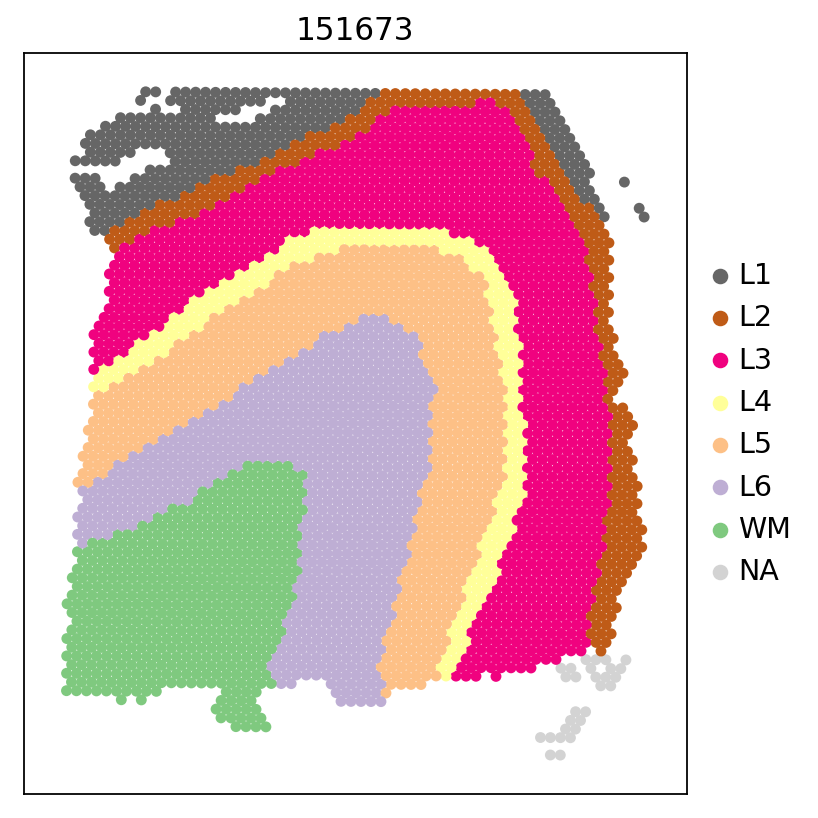

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout=True)

sc.pl.spatial(
    adata_spatialLIBD_d[SAMPLE_ID_N],
    img_key=None,
    color="spatialLIBD",
    palette="Accent_r",
    size=1.5,
    title=SAMPLE_ID_N,
    # legend_loc = 4,
    spot_size=100,
    show=False,
    ax=ax,
)

ax.axis("equal")
ax.set_xlabel("")
ax.set_ylabel("")

fig.show()


/tmp/ipykernel_53662/12672146.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_53662/12672146.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


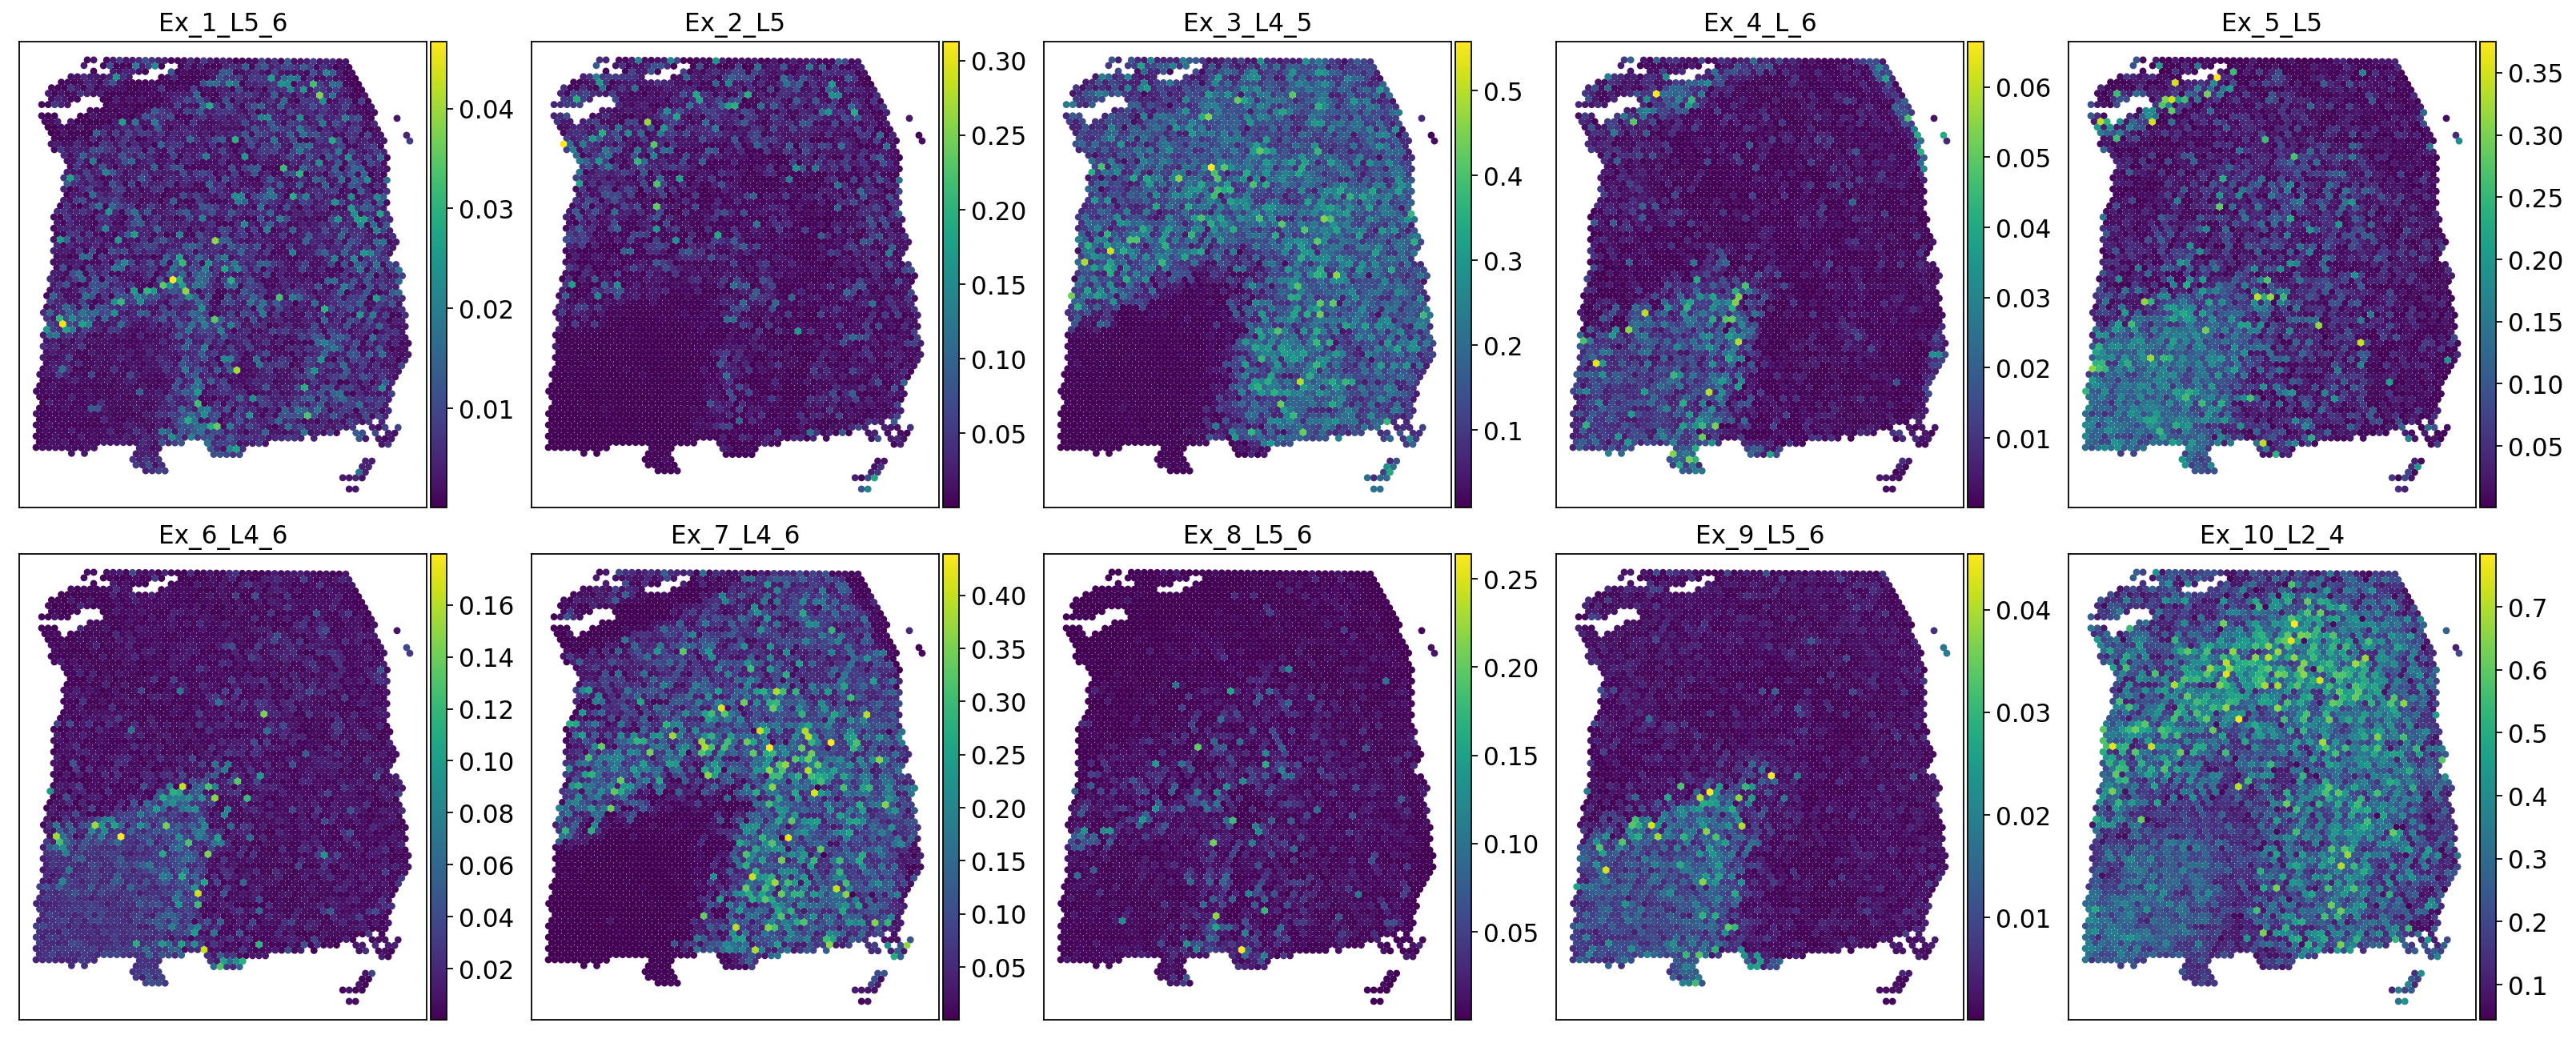

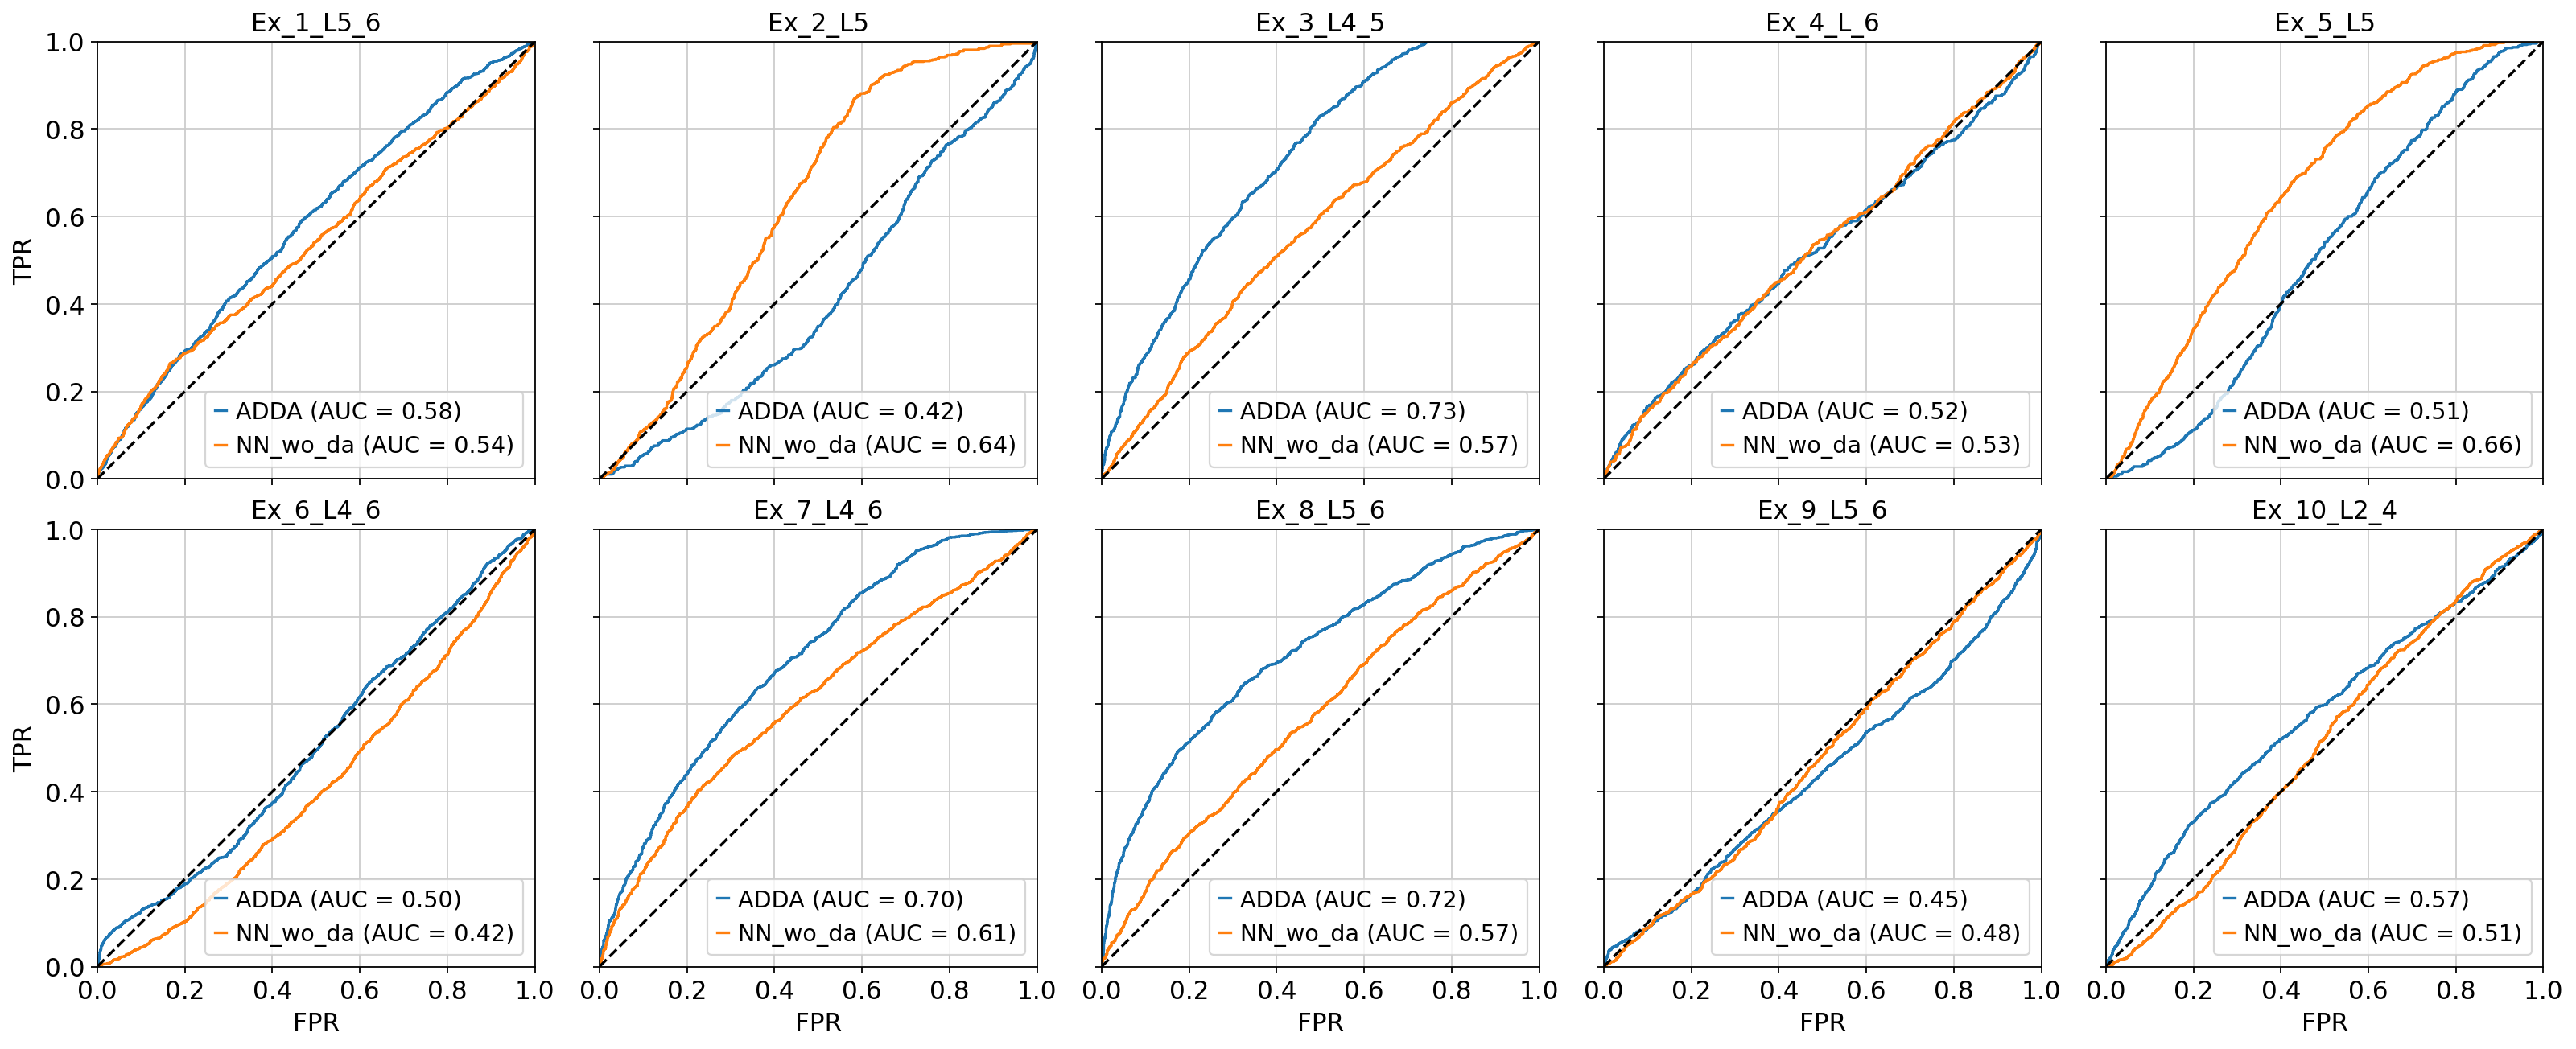

In [30]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8), constrained_layout=True)

for i, num in enumerate(numlist):
    plot_cellfraction(
        num, adata_spatialLIBD_d[SAMPLE_ID_N], pred_sp_d[SAMPLE_ID_N], ax.flat[i]
    )
    ax.flat[i].axis("equal")
    ax.flat[i].set_xlabel("")
    ax.flat[i].set_ylabel("")

fig.show()

fig, ax = plt.subplots(
    2, 5, figsize=(20, 8), constrained_layout=True, sharex=True, sharey=True
)

for i, num in enumerate(numlist):
    plot_roc(
        num,
        adata_spatialLIBD_d[SAMPLE_ID_N],
        pred_sp_d[SAMPLE_ID_N],
        "ADDA",
        ax.flat[i],
    )
    plot_roc(
        num,
        adata_spatialLIBD_d[SAMPLE_ID_N],
        pred_sp_noda_d[SAMPLE_ID_N],
        "NN_wo_da",
        ax.flat[i],
    )
    ax.flat[i].plot([0, 1], [0, 1], transform=ax.flat[i].transAxes, ls="--", color="k")
    ax.flat[i].set_aspect("equal")
    ax.flat[i].set_xlim([0, 1])
    ax.flat[i].set_ylim([0, 1])

    ax.flat[i].set_title(f"{sc_sub_dict[num]}")

    if i >= len(numlist) - 5:
        ax.flat[i].set_xlabel("FPR")
    else:
        ax.flat[i].set_xlabel("")
    if i % 5 == 0:
        ax.flat[i].set_ylabel("TPR")
    else:
        ax.flat[i].set_ylabel("")

fig.show()


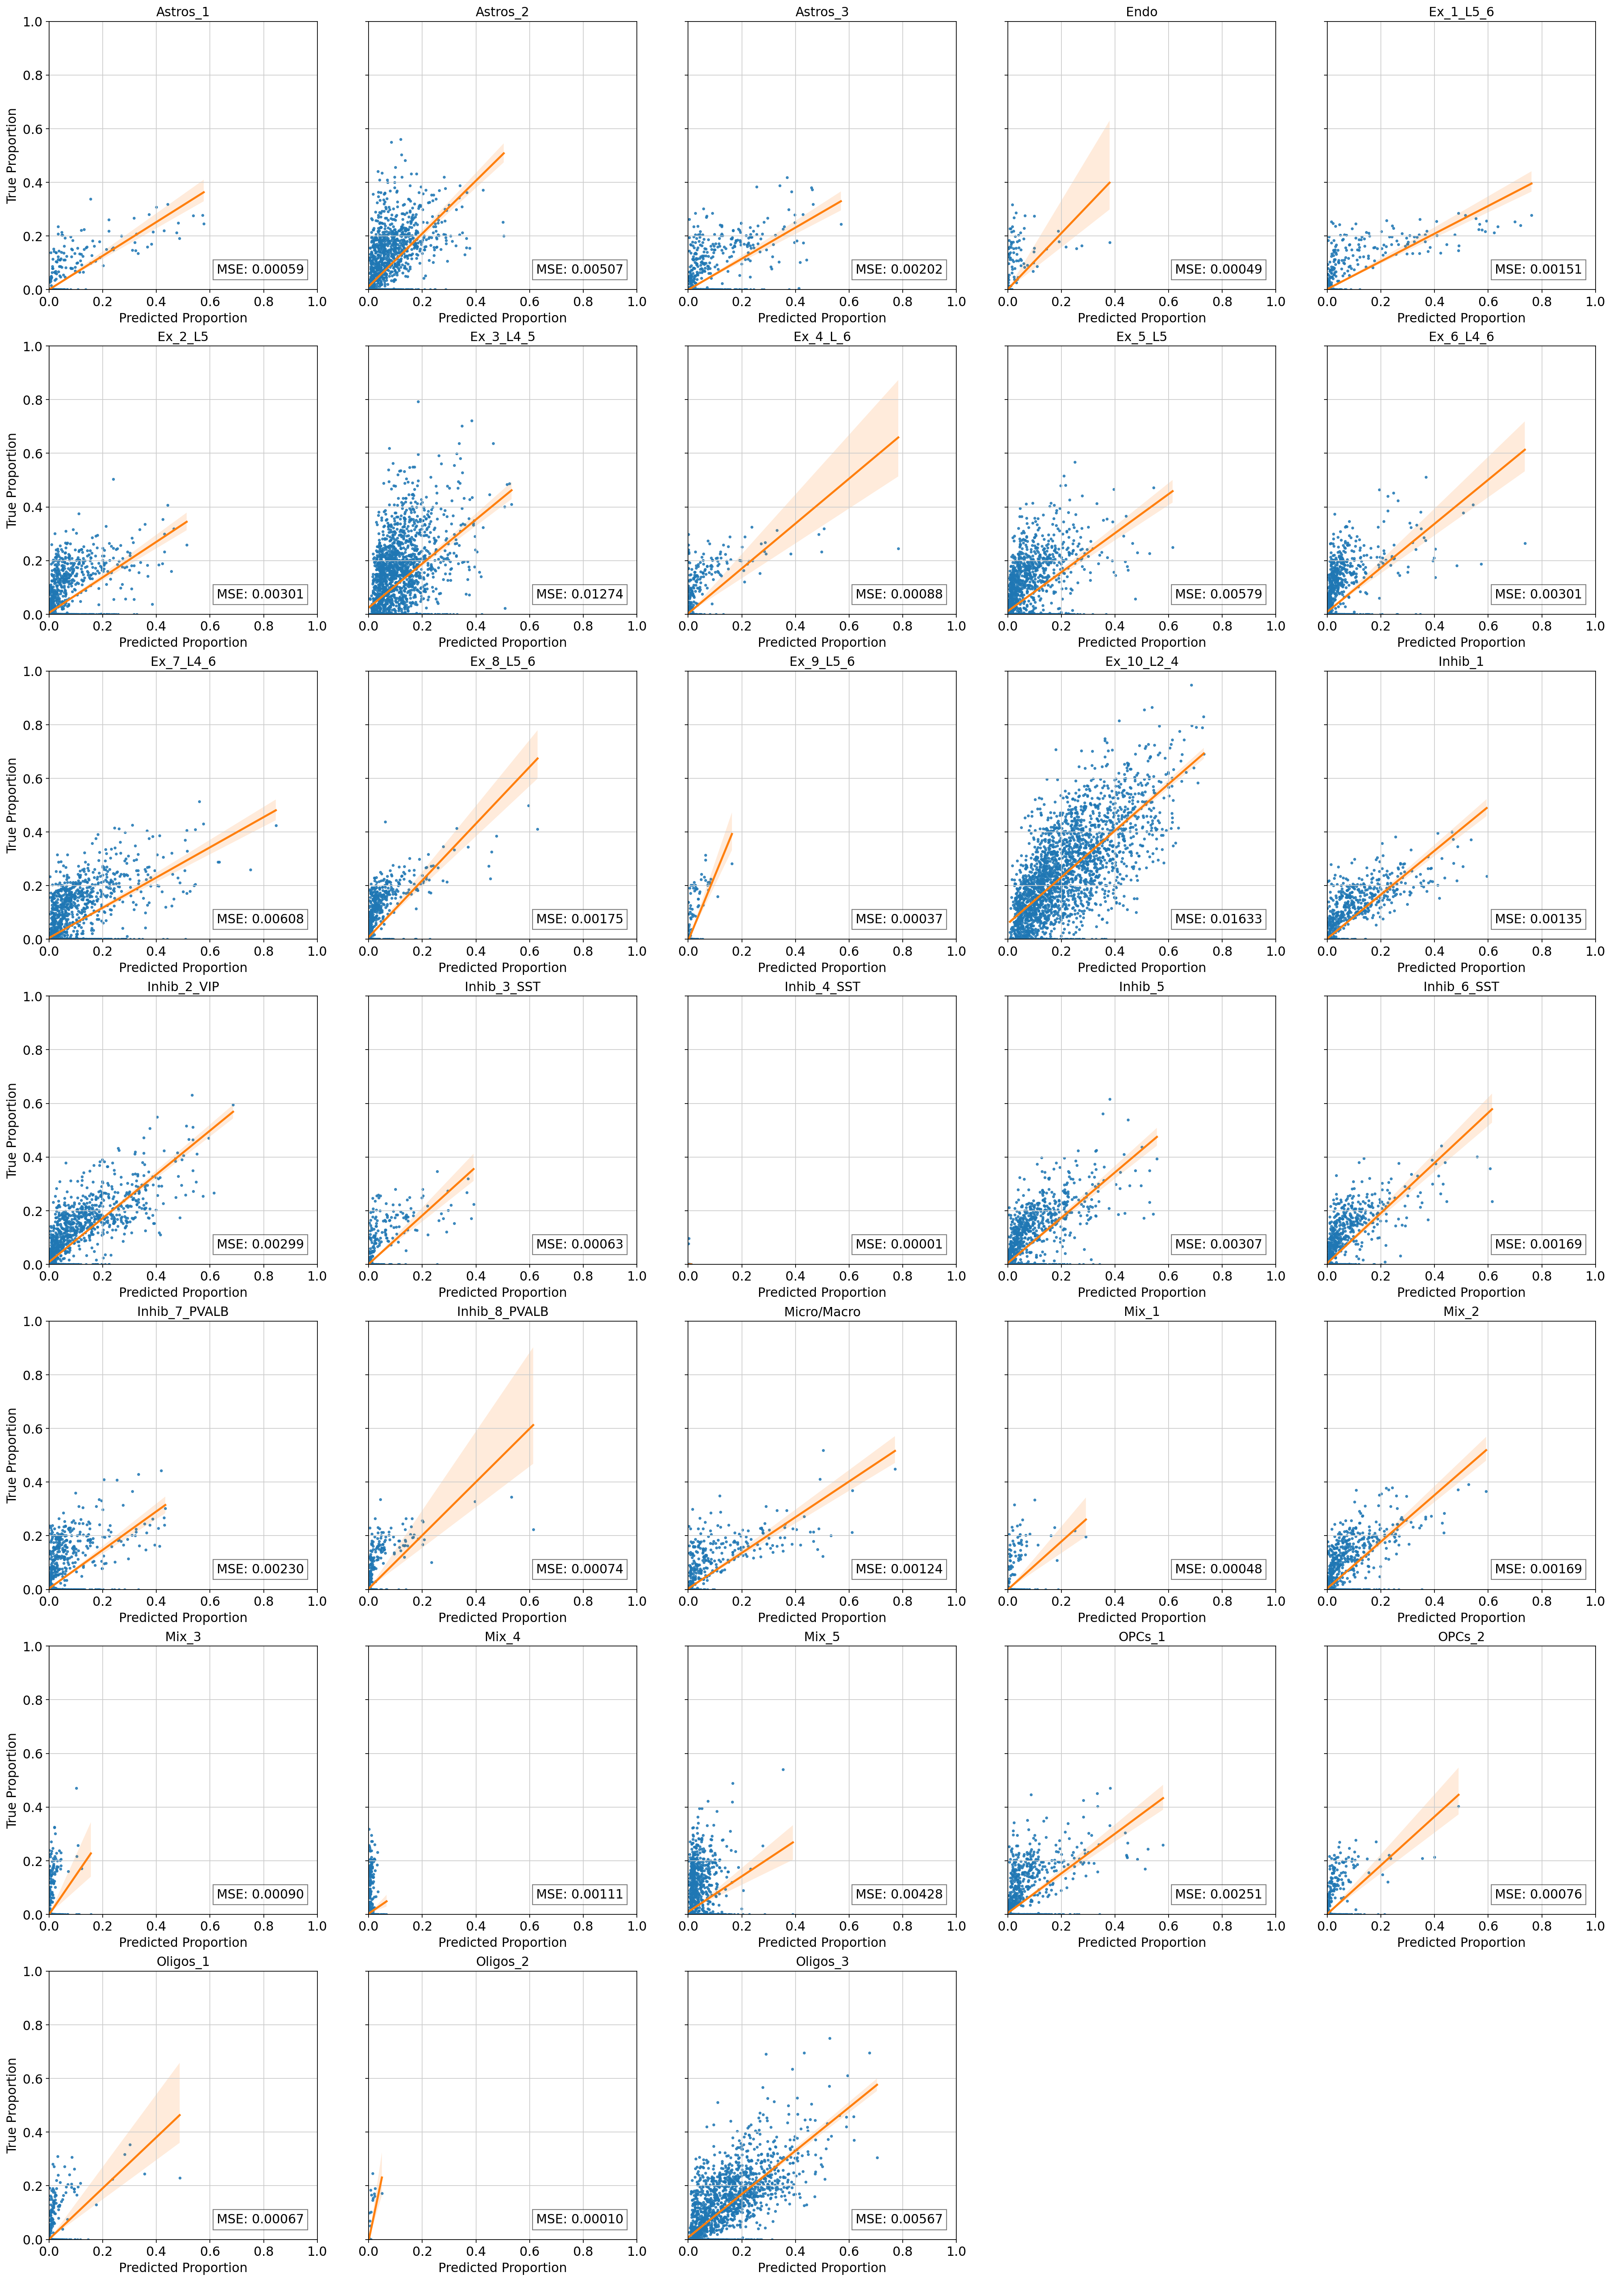

In [31]:
if TRAIN_USING_ALL_ST_SAMPLES:
    best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
else:
    best_checkpoint = torch.load(
        os.path.join(advtrain_folder, SAMPLE_ID_N, f"final_model.pth")
    )

model = best_checkpoint["model"]
model.to(device)

model.eval()
model.set_encoder("source")

with torch.no_grad():
    pred_mix = (
        torch.exp(model(torch.Tensor(sc_mix_test_s).to(device)))
        .detach()
        .cpu()
        .numpy()
    )

cell_type_nums = sc_sub_dict.keys()
nrows = ceil(len(cell_type_nums) / 5)

line_kws = {"color": "tab:orange"}
scatter_kws = {"s": 5}

props = dict(facecolor="w", alpha=0.5)

fig, ax = plt.subplots(
    nrows,
    5,
    figsize=(25, 5 * nrows),
    constrained_layout=True,
    sharex=False,
    sharey=True,
)
for i, visnum in enumerate(cell_type_nums):
    sns.regplot(
        x=pred_mix[:, visnum],
        y=lab_mix_test[:, visnum],
        line_kws=line_kws,
        scatter_kws=scatter_kws,
        ax=ax.flat[i],
    ).set_title(sc_sub_dict[visnum])

    ax.flat[i].set_aspect("equal")
    ax.flat[i].set_xlabel("Predicted Proportion")

    if i % 5 == 0:
        ax.flat[i].set_ylabel("True Proportion")
    else:
        ax.flat[i].set_ylabel("")
    ax.flat[i].set_xlim([0, 1])
    ax.flat[i].set_ylim([0, 1])

    textstr = (
        f"MSE: {mean_squared_error(pred_mix[:,visnum], lab_mix_test[:,visnum]):.5f}"
    )

    # place a text box in upper left in axes coords
    ax.flat[i].text(
        0.95,
        0.05,
        textstr,
        transform=ax.flat[i].transAxes,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=props,
    )

for i in range(len(cell_type_nums), nrows * 5):
    ax.flat[i].axis("off")

plt.show()
